## Import module

### Install adversial attack


In [ ]:
!pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.25.1 which is incompatible.
tweepy 4.13.0 requires requests<3,>=2.27.0, but you have requests 2.25.1 which is inco

### Import area

In [ ]:
import os
import math
import random
import torch

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from collections import Counter
from tqdm import tqdm

from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.io import read_image
from torchvision import models

import torchattacks

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Prepare dataset


### Load data

In [ ]:
dataset_path = './gdrive/MyDrive/資安/Test'

In [ ]:
#class_names = os.listdir(dataset_path)
class_names = ['Angelina Jolie', 'Hugh Jackman', 'Leonardo DiCaprio', 'Denzel Washington', 'Megan Fox', 'Natalie Portman', 'Brad Pitt', 'Kate Winslet', 'Jennifer Lawrence', 'Johnny Depp', 'Tom Hanks', 'Sandra Bullock', 'Robert Downey Jr', 'Nicole Kidman', 'Scarlett Johansson', 'Will Smith', 'Tom Cruise']
print(class_names)

['Angelina Jolie', 'Hugh Jackman', 'Leonardo DiCaprio', 'Denzel Washington', 'Megan Fox', 'Natalie Portman', 'Brad Pitt', 'Kate Winslet', 'Jennifer Lawrence', 'Johnny Depp', 'Tom Hanks', 'Sandra Bullock', 'Robert Downey Jr', 'Nicole Kidman', 'Scarlett Johansson', 'Will Smith', 'Tom Cruise']


In [ ]:
image_path_list = []
image_list = []
label_list = []

In [ ]:
temp_count = 0
for idx, class_name in enumerate(class_names):
  imgs = os.listdir(os.path.join(dataset_path, class_name))
  for i, img in enumerate(imgs):
    path = os.path.join(dataset_path, class_name, img)
    image_path_list.append(path)
    image_list.append(temp_count)
    label_list.append(idx)
    temp_count += 1

In [ ]:
print(image_path_list)
print(image_list)
print(label_list)

['./gdrive/MyDrive/資安/Test/Angelina Jolie/Angelina Jolie_9.png', './gdrive/MyDrive/資安/Test/Angelina Jolie/Angelina Jolie_0.png', './gdrive/MyDrive/資安/Test/Angelina Jolie/Angelina Jolie_2.png', './gdrive/MyDrive/資安/Test/Angelina Jolie/Angelina Jolie_3.png', './gdrive/MyDrive/資安/Test/Angelina Jolie/Angelina Jolie_4.png', './gdrive/MyDrive/資安/Test/Angelina Jolie/Angelina Jolie_1.png', './gdrive/MyDrive/資安/Test/Angelina Jolie/Angelina Jolie_6.png', './gdrive/MyDrive/資安/Test/Angelina Jolie/Angelina Jolie_7.png', './gdrive/MyDrive/資安/Test/Angelina Jolie/Angelina Jolie_5.png', './gdrive/MyDrive/資安/Test/Angelina Jolie/Angelina Jolie_8.png', './gdrive/MyDrive/資安/Test/Hugh Jackman/Hugh Jackman_0.png', './gdrive/MyDrive/資安/Test/Hugh Jackman/Hugh Jackman_1.png', './gdrive/MyDrive/資安/Test/Hugh Jackman/Hugh Jackman_2.png', './gdrive/MyDrive/資安/Test/Hugh Jackman/Hugh Jackman_4.png', './gdrive/MyDrive/資安/Test/Hugh Jackman/Hugh Jackman_3.png', './gdrive/MyDrive/資安/Test/Hugh Jackman/Hugh Jackman_6.png',

In [ ]:
print("Length:", len(image_list))

Length: 170


### Make dataset

In [ ]:
class myDataset(Dataset):
    def __init__(self, img_idxs, img_labels, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.img_idxs = img_idxs
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image_idx = self.img_idxs[idx]
        image = read_image(image_path_list[image_idx])
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
dataset = myDataset(image_list, label_list)
print(len(dataset))

170


### Have a glance

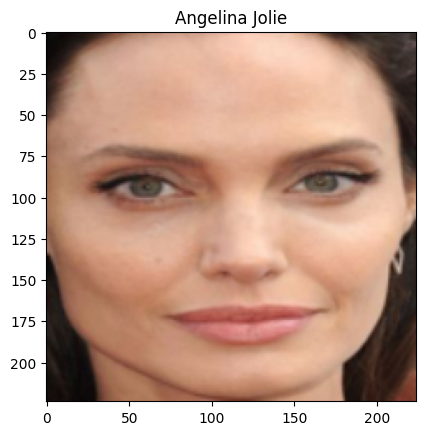

In [ ]:
show_img, show_lbl = dataset[0]

plt.imshow(show_img.permute(1, 2, 0))
plt.title(class_names[show_lbl])
plt.show()

## Preprocess

#### Regular

In [ ]:
tform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [ ]:
tform_clean = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor()
])

## Model Architecture

### Config

In [ ]:
class Config:
  epoch = 30
  batch_size = 64
  num_workers = 0
  lr = [1e-6, 1e-4, 1e-2]
  lr_step = 30
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  patience = 3
  checkpoints = "./gdrive/MyDrive/資安/atk checkpoints"
  test_model = ""

### Model


#### Model Architecture

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(512, len(class_names), bias=True)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.1MB/s]


#### Loss function

In [ ]:
criterion = nn.CrossEntropyLoss()

#### Checkpoints


In [ ]:
# Checkpoints Setup
os.makedirs(Config.checkpoints, exist_ok=True)

In [ ]:
def optimizer_to(optim, device):
    for param in optim.state.values():
        # Not sure there are any global tensors in the state dict
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)

#### Load model

In [ ]:
try:
  weight_list = os.listdir(Config.checkpoints)
  weight_list = [w.split('.')[0] for w in weight_list]
  lastest_weight = f"{weight_list[-1]}.pth"
  best_weight_dir = os.path.join(Config.checkpoints, lastest_weight)
  checkpoint = torch.load(best_weight_dir, map_location=Config.device)
  model.load_state_dict(checkpoint['model_state_dict'])
  last_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  Config.test_model = best_weight_dir
  print(f"Load best weight path:{best_weight_dir}, epoch:{last_epoch} / {Config.epoch}, loss:{loss}")
except Exception as e:
  print(e)

Load best weight path:./gdrive/MyDrive/資安/atk checkpoints/8.pth, epoch:8 / 30, loss:0.22241781651973724


## Adversial attack

In [ ]:
torchAtk_PGD = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=4)
torchAtk_FGSM = torchattacks.FGSM(model, eps=8/255)
torchAtk_Ensemble = torchattacks.MultiAttack([torchAtk_PGD, torchAtk_FGSM])

In [ ]:
atk_list = ["FGSM", "PGD", "Multi_attack"]
eps_list = [2/255, 4/255, 8/255]

torch.backends.cudnn.deterministic = True

atk_model_list = [torchAtk_PGD, torchAtk_FGSM, torchAtk_Ensemble]

### Image generation

In [ ]:
for name in atk_list:
  for eps in eps_list:
    root_path = f"./gdrive/MyDrive/資安/Experiment/{name}_{int(eps*255)}"
    os.makedirs(root_path, exist_ok=True)

    if name == "FGSM":
      method = torchattacks.FGSM(model, eps=eps)
      print("FGSM")
    elif name == "PGD":
      method = torchattacks.PGD(model, eps=eps, alpha=2/255, steps=4)
      print("PGD")
    elif name == "Multi_attack":
      torchAtk_PGD = torchattacks.PGD(model, eps=eps, alpha=2/255, steps=4)
      torchAtk_FGSM = torchattacks.FGSM(model, eps=eps)
      method = torchattacks.MultiAttack([torchAtk_PGD, torchAtk_FGSM])
      print("Multi")

    #Class dir
    for lbl in label_list:
      os.makedirs(os.path.join(root_path, class_names[lbl]), exist_ok=True)

    counter = 0
    last_lbl = ""
    for img, lbl in zip(image_list, label_list):
      #Img process
      image = Image.open(image_path_list[img])
      x = tform_clean(image)
      x = x.unsqueeze(0)
      y = torch.tensor(lbl)
      y = y.unsqueeze(0)
      adv_img = method(x, y)
      adv_img = torch.squeeze(adv_img)
      img_save = transforms.ToPILImage()(adv_img)
      if lbl != last_lbl:
        counter = 0
        last_lbl = lbl
      else:
        counter += 1
      #Path make
      img_save.save(os.path.join(root_path, class_names[lbl], os.path.basename(image_path_list[img])))


FGSM
FGSM
FGSM
PGD
PGD
PGD
Multi
Multi
Multi
